# Brands and products emotion dataset analisys 

In [1]:
#Importing important stuff
import string
import re
import pandas as pd
import unittest
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
#weee

In [2]:
#Loading in dataset
df = pd.read_csv('tweets.csv', dtype=str)

In [3]:
df = df.rename(columns = { 'emotion_in_tweet_is_directed_at':'products',
            'is_there_an_emotion_directed_at_a_brand_or_product':'emotions'})
df = df.set_index('index')

# Entry analisys

In [4]:
df.describe()

,tweet_text,products,emotions
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [5]:
products= df['products'].value_counts(dropna=False)
emotions=df['emotions'].value_counts(dropna=False)

Text(0.5, 1.0, 'Opinions on product distribution')

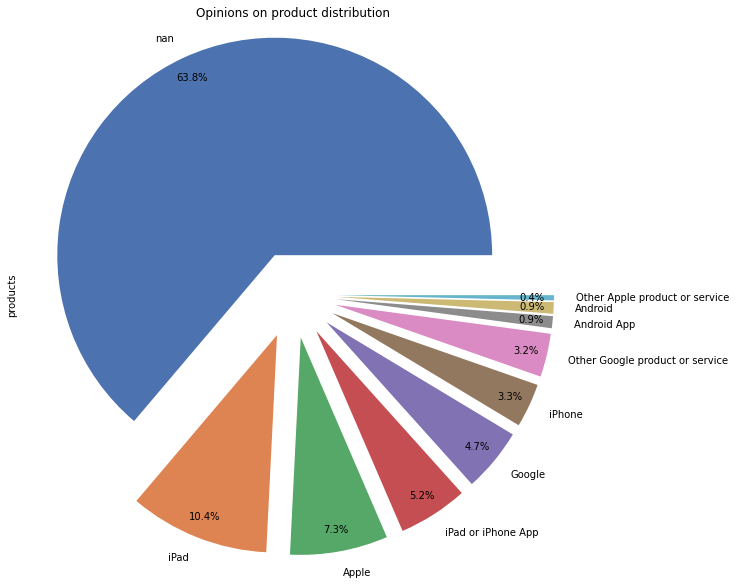

In [6]:
distance = [0.2 for i in products]
labels = ['' for i in products]
colors = sns.color_palette('deep')

plt.figure(figsize=(10,10))
ax = products.plot.pie(autopct='%1.1f%%', colors=colors, explode=distance, grid=False, pctdistance=0.90)
ax.set_title('Opinions on product distribution')

Text(0.5, 1.0, 'Emotions distribution')

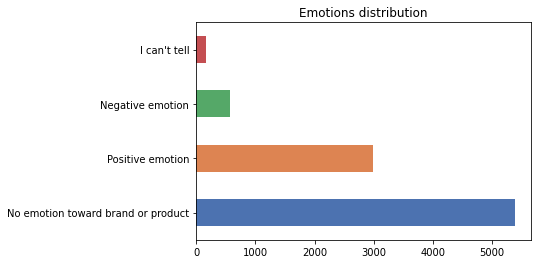

In [7]:

ax3 = emotions.plot(kind='barh',color=colors)
ax3.set_title('Emotions distribution')

# Text normalization

In [8]:
df.tweet_text = df.tweet_text.astype(str)

In [9]:
df.tweet_text = df.tweet_text.apply(lambda x: x.lower())

In [10]:
def cleanseText(textColumn):
    textColumn = textColumn.apply(lambda x: re.sub("@\w+","",x))
    textColumn = textColumn.apply(lambda x: x.lower())
    textColumn = textColumn.apply(lambda x: re.sub(r'\d+','',x))
    textColumn = textColumn.apply(lambda x: re.sub(r'{link}','',x))
    textColumn = textColumn.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    textColumn = textColumn.apply(lambda x: x.strip())

    return textColumn
    

In [11]:
df.tweet_text = cleanseText(df.tweet_text)

In [12]:
df.tweet_text.head(30)

index
0     i have a g iphone after  hrs tweeting at risea...
1     know about   awesome ipadiphone app that youll...
2     can not wait for ipad  also they should sale t...
3     i hope this years festival isnt as crashy as t...
4     great stuff on fri sxsw marissa mayer google t...
5     new ipad apps for speechtherapy and communicat...
6                                                   nan
7     sxsw is just starting ctia is around the corne...
8     beautifully smart and simple idea rt   wrote a...
9     counting down the days to sxsw plus strong can...
10    excited to meet the  at sxsw so i can show the...
11    find amp start impromptu parties at sxsw with ...
12    foursquare ups the game just in time for sxsw ...
13    gotta love this sxsw google calendar featuring...
14         great sxsw ipad app from  httptinyurlcomnqvl
15    haha awesomely rad ipad app by  httpbitlyhtdfi...
16    holler gram for ipad on the itunes app store  ...
17    i just noticed dst is coming this we

'Tekst     dla ciebie'